In [126]:
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from sklearn import svm
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec


In [127]:
!git clone https://github.com/tanahusarova/MLprojekt
%cd MLprojekt

df_train = pd.read_csv('chat_dataset_edited.csv')

def get_label_vec(y, classes):
  ret = [classes[i] for i in y]
  return ret

X_train, X_test, y_train, y_test = train_test_split(df_train['message'], df_train['sentiment'], test_size=0.20, random_state=41)
classes = {'neutral': 0, 'passive-aggressive': 1}

y_train = get_label_vec(y_train, classes)
y_test = get_label_vec(y_test, classes)


Cloning into 'MLprojekt'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (5/5), 18.99 KiB | 3.80 MiB/s, done.
/content/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt/MLprojekt


In [128]:
def remove_stop_words(data, stop_words):
  data_new = []
  for lyrics in data:
    data_new.append([i.lower() for i in lyrics.split() if i.lower() not in stop_words])
  return data_new

stop_words = np.loadtxt('stop_words.csv', delimiter=',', dtype='str')
X_train_cleared = remove_stop_words(X_train, stop_words)
X_test_cleared = remove_stop_words(X_test, stop_words)


In [129]:
porter = PorterStemmer()

def stem_words(data, stem):
  data_new = []
  for lyrics in data:
    data_new.append([porter.stem(i) for i in lyrics])
  return data_new

porter = PorterStemmer()
X_train_cleared = stem_words(X_train_cleared, porter.stem)
X_test_cleared = stem_words(X_test_cleared, porter.stem)

idx = np.random.randint(len(X_train_cleared), size=5)
classes_inv = {0: 'neutral', 1: 'passive-aggressive'}

for i in idx:
    print("{}: {}".format(classes_inv[y_train[i]], X_train_cleared[i]))


neutral: ['weather', 'perfect', 'today']
passive-aggressive: ['well,', "that'", 'certainli', 'differ']
neutral: ['strong', 'opinion']
neutral: ["didn't", 'consid', 'perspective;', 'apolog', 'oversight']
passive-aggressive: ["i'm", 'amaz', 'incred', 'attent', 'detail']


In [130]:
from collections import Counter

def join(X, y, label):
  common_words = ' '
  for i in range(0, len(X)):
    if y[i] == label:
      for j in range(0, len(X[i])):
        common_words = common_words + " " + X[i][j]
  return common_words

passive_aggressive_words = join(X_train_cleared, all_labels, 1) + join(X_test_cleared, all_labels, 1)
non_passive_aggressive_words = join(X_train_cleared, all_labels, 0) + join(X_test_cleared, all_labels, 0)

passive_aggressive_word_freq = Counter(passive_aggressive_words.split()).most_common(20)
non_passive_aggressive_word_freq = Counter(non_passive_aggressive_words.split()).most_common(20)

print("Most common 20 Passive-Aggressive:", passive_aggressive_word_freq)
print("Most common 20 Non-Passive-Aggressive:", non_passive_aggressive_word_freq)

Most common 20 Passive-Aggressive: [("i'm", 91), ("you'r", 39), ('alway', 25), ('feel', 23), ("it'", 23), ('certainli', 19), ("you'v", 17), ('love', 14), ('thing', 13), ('sure', 13), ('truli', 12), ('find', 12), ('time', 12), ("don't", 11), ('bit', 11), ('know', 11), ('appreci', 11), ("that'", 11), ('interest', 10), ('today', 10)]
Most common 20 Non-Passive-Aggressive: [("i'm", 161), ("you'r", 58), ('alway', 46), ('feel', 42), ("it'", 40), ("that'", 34), ('critic', 29), ('love', 28), ('sure', 27), ('averag', 24), ('way', 23), ("you'v", 23), ('know', 22), ('thing', 22), ('certainli', 21), ('see', 21), ('approach', 20), ('like', 20), ('one', 19), ('feedback', 19)]


In [131]:
def transform_bag(data, vocab):
    matrix = []
    for d in data:
      matrix.append([1 if i in d else 0 for i in vocab])
    res = np.asarray(matrix)
    return res

vocabulary = np.loadtxt('vocabulary.csv', delimiter=',', dtype='str').tolist()

X_train_cleared = transform_bag(X_train_cleared, vocabulary)
X_test_cleared = transform_bag(X_test_cleared, vocabulary)

In [132]:
def predict_constant(data):
    m = np.mean(data)
    if m < 0.5:
      m = 1 - m
    return m

print("Testing accuracy for constant: {}".format(predict_constant(y_test)))

best_score = 0

for c in range(1, 51, 5):
  for g in range(1, 22, 5):
    svc = svm.SVC(C=c, gamma=g, kernel='rbf')
    svc.fit(X_train_cleared, y_train)
    score = svc.score(X_test_cleared, y_test)
    if (score > best_score):
      best_score = score

print("Best testing accuracy for SVM: {}".format(best_score))

best_score = 0

for d in range(50, 100, 5):
  for e in range(10, 60, 5):
    rfc = RandomForestClassifier(n_estimators=e, max_depth=d)
    rfc.fit(X_train_cleared, y_train)
    score = rfc.score(X_test_cleared, y_test)
    if (score > best_score):
      best_score = score

print("Best testing accuracy for Random Forest: {}".format(best_score))

best_score = 0

for c in range(1, 30, 5):
  lr = LogisticRegression(verbose=5, C=c)
  lr.fit(X_train_cleared, y_train)
  score = lr.score(X_test_cleared, y_test)
  if (score > best_score):
      best_score = score

print("Best testing accuracy for logistic regression: {}".format(best_score))


Testing accuracy for constant: 0.6415094339622642
Best testing accuracy for SVM: 0.660377358490566
Best testing accuracy for Random Forest: 0.6792452830188679
Best testing accuracy for logistic regression: 0.6698113207547169


In [133]:
def tokenize_messages(X):
    matrix = []
    for m in X:
      matrix.append(m.split())
    return matrix

def w2v_modification(message, w2v):
    words = message.split()
    words = [w for w in words if w in w2v.wv]
    if len(words) == 0:
        return np.zeros(w2v.vector_size)
    word_vectors = [w2v.wv[word] for word in words]
    return np.mean(word_vectors, axis=0)

X_w2v = tokenize_messages(df_train["message"])
word2vec = Word2Vec(X_w2v, vector_size=100, window=5, min_count=1, sg=0)

X_train_word2vec = np.array([w2v_modification(message, word2vec) for message in X_train])
X_test_word2vec = np.array([w2v_modification(message, word2vec) for message in X_test])



In [134]:
print("Testing accuracy for constant: {}".format(predict_constant(y_test)))

best_score = 0

for c in range(1, 51, 10):
  for g in range(1, 22, 10):
    svc = svm.SVC(C=c, gamma=g, kernel='rbf')
    svc.fit(X_train_word2vec, y_train)
    score = svc.score(X_test_word2vec, y_test)
    if (score > best_score):
      best_score = score

print("Best testing accuracy for SVM with Word2Vec: {}".format(best_score))


best_score = 0

for d in range(50, 100, 5):
  for e in range(10, 60, 5):
    rfc = RandomForestClassifier(n_estimators=e, max_depth=d)
    rfc.fit(X_train_word2vec, y_train)
    score = rfc.score(X_test_word2vec, y_test)
    if (score > best_score):
      best_score = score

print("Best testing accuracy for Random Forest with Word2Vec: {}".format(best_score))


best_score = 0

for c in range(1, 30, 5):
  lr = LogisticRegression(verbose=5, C=c)
  lr.fit(X_train_word2vec, y_train)
  score = lr.score(X_test_word2vec, y_test)
  if (score > best_score):
      best_score = score

print("Best testing accuracy for logistic regression with Word2Vec: {}".format(best_score))


Testing accuracy for constant: 0.6415094339622642
Best testing accuracy for SVM with Word2Vec: 0.8066037735849056
Best testing accuracy for Random Forest with Word2Vec: 0.8207547169811321
Best testing accuracy for logistic regression with Word2Vec: 0.6415094339622641


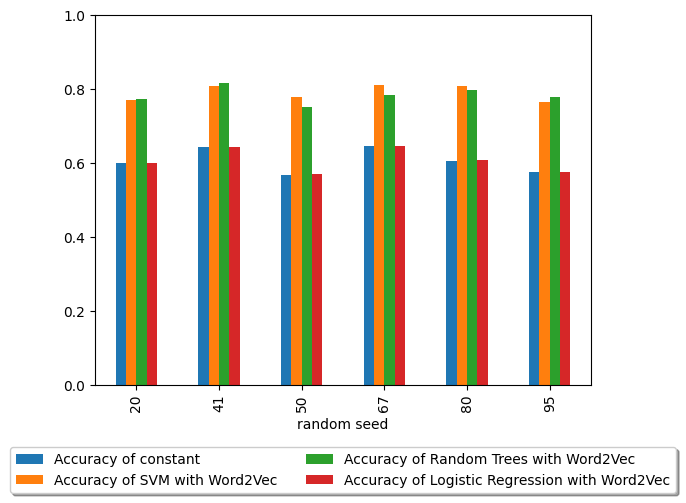

In [135]:
df = pd.DataFrame({
    'random seed': ['20', '41', '50', '67', '80', '95'],
    'Accuracy of constant': [0.5990566037735849, 0.6415094339622642, 0.5660377358490566, 0.6462264150943396, 0.6037735849056604, 0.5754716981132075],
    'Accuracy of SVM': [0.6179245283018868, 0.660377358490566, 0.5990566037735849, 0.6933962264150944, 0.6509433962264151, 0.6273584905660378],
    'Accuracy of Random Trees': [0.660377358490566, 0.6792452830188679, 0.6226415094339622, 0.7028301886792453, 0.6886792452830188, 0.6556603773584906],
    'Accuracy of Logistic Regression': [0.6367924528301887, 0.6698113207547169, 0.6037735849056604, 0.6933962264150944, 0.6792452830188679, 0.6367924528301887],

    'Accuracy of SVM with Word2Vec': [0.7688679245283019, 0.8066037735849056, 0.7783018867924528, 0.8113207547169812, 0.8066037735849056, 0.7641509433962265],
    'Accuracy of Random Trees with Word2Vec': [0.7735849056603774, 0.8160377358490566, 0.75, 0.7830188679245284, 0.7971698113207547, 0.7783018867924528],
    'Accuracy of Logistic Regression with Word2Vec': [0.5990566037735849, 0.6415094339622641, 0.5707547169811321, 0.6462264150943396, 0.6084905660377359, 0.5754716981132075]

})

df.plot(x="random seed", y=["Accuracy of constant", "Accuracy of SVM with Word2Vec", "Accuracy of Random Trees with Word2Vec", "Accuracy of Logistic Regression with Word2Vec"], kind="bar")
plt.ylim(0, 1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

